In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_train = pd.read_csv("../../Data/Final_train.csv")

In [4]:
df_train.info()
df = df_train.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            1647 non-null   int64  
 1   Kilometer                       1647 non-null   float64
 2   Length                          1647 non-null   float64
 3   Width                           1647 non-null   float64
 4   Height                          1647 non-null   float64
 5   Fuel Tank Capacity              1647 non-null   float64
 6   Log_Price                       1647 non-null   float64
 7   Engine_Value                    1647 non-null   float64
 8   Max_Power_Value                 1647 non-null   float64
 9   Max_Power_RPM                   1647 non-null   float64
 10  Max_Torque_Value                1647 non-null   float64
 11  Max_Torque_RPM                  1647 non-null   float64
 12  Make_encoded                    16

In [5]:
    # 'Year', 
    # 'Kilometer', 
    # 'Length', 
    # # 'Width', 
    # # 'Height', 
    # 'Fuel Tank Capacity',
    # # 'Engine_Value', 
    # 'Max_Power_Value', 
    # 'Max_Power_RPM',
    # 'Max_Torque_Value', 
    # # 'Max_Torque_RPM', 
    # 'Make_encoded',

    # 'Fuel_CNG',
    # 'Fuel_Others', 
    # 'Fuel_Petrol', 

    # 'Transmission_is_Automatic',

    # # 'Volume',
    # # 'Power_to_Weight',
    # 'Efficiency',
    # # 'Power_Density',
    # # 'Torque_Density',
    # 'Power_Torque_Ratio',
    # # 'Length_Width_interaction',


    # 'Color_Medium', 
    # 'Color_Premium', 
    # 'Color_Rare', 
    # 'Color_Silver',
    # 'Color_Standard', 
    
    # 'Owner_First_Owner', 
    # 'Owner_Fourth_Plus_Owner',
    # 'Owner_New', 
    # 'Owner_Second_Owner', 
    # 'Owner_Third_Owner',

    # 'Seller_Commercial Registration', 
    # 'Seller_Corporate', 
    
    # 'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8'

Ngưỡng giá để xác định outlier: 17586000.00
Số dòng đã loại bỏ: 9
Feature weights:
Year: 0.11910904
Kilometer: -0.18704626
Length: 0.17753318
Fuel Tank Capacity: 0.08830630
Max_Power_Value: 0.35936148
Max_Power_RPM: 0.02693290
Max_Torque_Value: -0.10673780
Make_encoded: 0.29372821
Fuel_CNG: -0.12427745
Fuel_Others: 0.15211320
Fuel_Petrol: -0.19162317
Transmission_is_Automatic: 0.21752969
Volume: -0.00002522
Efficiency: -0.00049189
Age_Volume: 0.00000277
Age_Kilometer: 0.00541660
Kilometer_per_Year: 0.69872463
Power_to_CC: 0.06517167
Power_to_Torque: -0.12701763
RPM_Ratio: -0.03083938
Color_Silver: -0.06046008
Owner_First_Owner: 0.10217272
Owner_Fourth_Plus_Owner: -0.56497697
Owner_New: 0.31430774
Owner_Second_Owner: 0.06386538
Owner_Third_Owner: 0.08463114
Seating_2: 0.98902917
Seating_4: 0.07510045
Seating_6: 0.04592770
Seating_7: 0.04136149
Seating_8: -0.01994515
Intercept: -226.46370650

Metrics for Log_Price:
MSE: 0.0547
MAE: 0.1735
R^2: 0.9347

Metrics for Actual Price (exponentia

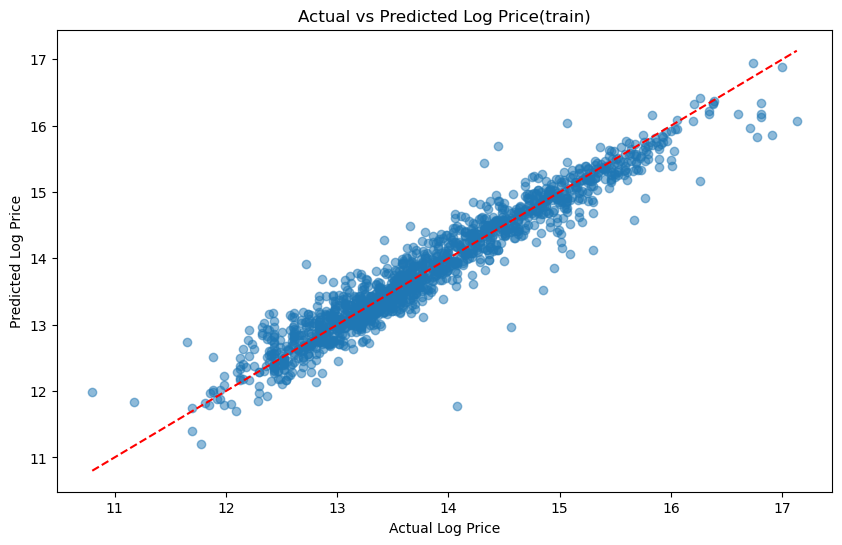


Metrics for Log Price (train) (exponentiated):
MSE: 0.0722
MAE: 0.1908
R^2: 0.9638


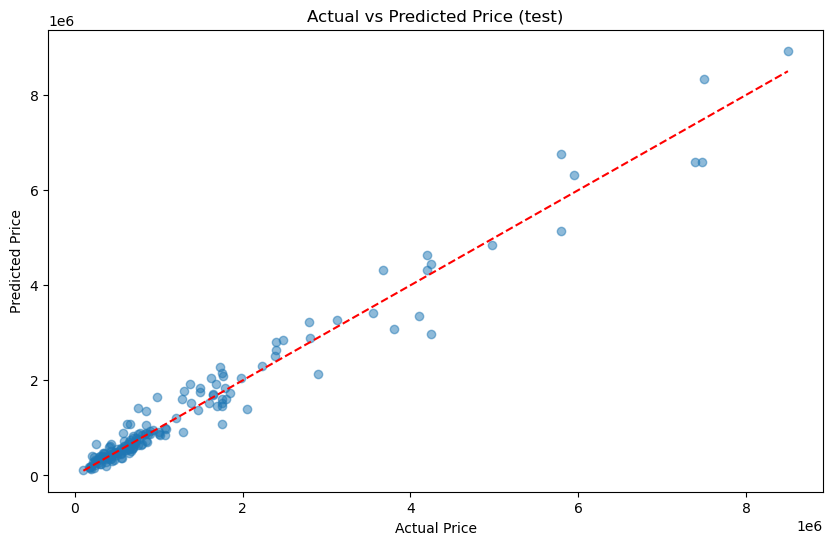

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Đọc dữ liệu
df_train = pd.read_csv('../../Data/Final_train.csv')
df_train['Price'] = np.exp(df_train['Log_Price'])

# # Hiển thị phân phối của Price
# plt.figure(figsize=(10, 6))
# sns.histplot(df_train['Price'], kde=True)
# plt.title('Phân phối của giá')
# plt.xscale('log')
# plt.show()

# Cell 3: Loại bỏ các outlier
# Tính toán ngưỡng để xác định outlier (ví dụ: giá cao hơn 99.5%)
price_threshold = df_train['Price'].quantile(0.995)
print(f"Ngưỡng giá để xác định outlier: {price_threshold:.2f}")

# Loại bỏ các dòng có giá quá cao
df_clean = df_train[df_train['Price'] <= price_threshold].copy()
print(f"Số dòng đã loại bỏ: {len(df_train) - len(df_clean)}")
df = df_train.copy()
df['Volume'] = df_train['Length'] * df_train['Width'] * df_train['Height']
df['Power_to_Weight'] = df['Max_Power_Value'] / df['Volume']
df['Efficiency'] = df['Max_Power_Value'] / df['Fuel Tank Capacity']

# 3. Tương tác RPM
df['Power_Density'] = df['Max_Power_Value'] / df['Max_Power_RPM']
df['Torque_Density'] = df['Max_Torque_Value'] / df['Max_Torque_RPM']

# 4. Tỷ lệ Power/Torque
df['Power_Torque_Ratio'] = df['Max_Power_Value'] / df['Max_Torque_Value']
df['Length_Width_interaction'] = df['Length'] * df['Width']
df['Kilometer_Log'] = np.log(df['Kilometer'] - df['Kilometer'].min() + 1e-3)
df_train = df

for col in ['Year', 'Kilometer', 'Length', 'Width', 'Height', 'Fuel Tank Capacity', 
           'Engine_Value', 'Max_Power_Value', 'Max_Power_RPM', 'Max_Torque_Value', 'Max_Torque_RPM']:
    if col in df_train.columns:
        # Biến đổi logarithm: hữu ích cho các biến dạng phân phối skewed
        try:   
            df_train[f'{col}_log'] = np.log1p(df_train[col].clip(lower=0.001))
        except:
            print(f"Error while creating log {col}")
        
        # Biến đổi bình phương: capture mối quan hệ phi tuyến
        df_train[f'{col}_squared'] = df_train[col]**2

# FEATFEAT
df_train['Volume'] = df_train['Length'] * df_train['Width'] * df_train['Height']
df_train['Age'] = 2025 - df_train['Year']
df_train['Age_Volume'] = df_train['Age'] * df_train['Volume']
df_train['Age_Kilometer'] = df_train['Age'] * df_train['Kilometer']
df_train['Kilometer_per_Year'] = df_train['Kilometer'] / df_train['Age'].clip(lower=1)

# 3. Các tỉ lệ kỹ thuật quan trọng
df_train['Power_to_Weight'] = df_train['Max_Power_Value'] / df_train['Volume'].clip(lower=1)
df_train['Power_to_CC'] = df_train['Max_Power_Value'] / df_train['Engine_Value'].clip(lower=1)
df_train['Torque_to_CC'] = df_train['Max_Torque_Value'] / df_train['Engine_Value'].clip(lower=1)
df_train['Power_to_Torque'] = df_train['Max_Power_Value'] / df_train['Max_Torque_Value'].clip(lower=1)
df_train['RPM_Ratio'] = df_train['Max_Power_RPM'] / df_train['Max_Torque_RPM'].clip(lower=1)

# 4. Các biến phi tuyến phức tạp (capturing domain knowledge)
df_train['Efficiency_Index'] = df_train['Max_Power_Value'] / (df_train['Engine_Value'] * df_train['Fuel Tank Capacity']).clip(lower=1)
df_train['Performance_Index'] = (df_train['Max_Power_Value'] * df_train['Max_Torque_Value']) / df_train['Engine_Value'].clip(lower=1)
df_train['Luxury_Index'] = df_train['Volume'] * df_train['Max_Power_Value'] / 1000
df_train['Size_Ratio'] = df_train['Length'] / df_train['Width'].clip(lower=1)
df_train['Space_Efficiency'] = df_train['Volume'] / df_train['Engine_Value'].clip(lower=1)

# 5. Polynomial features cho các biến kỹ thuật quan trọng
df_train['Power_Polynomial'] = df_train['Max_Power_Value']**2 / df_train['Engine_Value'].clip(lower=1)
df_train['Mileage_Decay'] = np.exp(-df_train['Kilometer'] / 100000)  # Hiệu ứng giảm giá theo số km theo hàm mũ
df_train['Premium_Power'] = df_train['Max_Power_Value'] * (df_train['Make_encoded'] > 5).astype(int)  # Tương tác giữa hãng cao cấp và công suất


# Chọn các features (THAY ĐỔI FEATURES Ở ĐÂY)
selected_features = [
    'Year', # Chọn cứng feat này
    'Kilometer', # Chọn cứng
    'Length', # Không chắc
    'Fuel Tank Capacity', # Không chắc
    # 'Engine_Value',
    'Max_Power_Value', # Không chắc
    'Max_Power_RPM', # Không chắc
    'Max_Torque_Value', # Không chắc
    # 'Max_Torque_RPM', 
    'Make_encoded', # Chọn cứng

    # Nếu chọn thì chọn tất cả Fuel_%
    'Fuel_CNG',
    'Fuel_Others', 
    'Fuel_Petrol', 


    'Transmission_is_Automatic', # Không chắc


    'Volume', # Không chắc
    # 'Power_to_Weight', # Không chắc
    'Efficiency', # Không chắc
    # 'Power_Density', # Có thể nhưng không nên sài
    # 'Torque_Density', # Có thể nhưng không nên sài
    # 'Power_Torque_Ratio', # Có thể nhưng không nên sài
    # 'Length_Width_interaction', # Có thể nhưng không nên sài
    'Age_Volume', # Không chắc
    'Age_Kilometer', # Không chắc
    'Kilometer_per_Year', # Không chắc
    'Power_to_CC', # Không chắc
    # 'Torque_to_CC', # Có thể nhưng không nên sài
    'Power_to_Torque', # Không chắc
    'RPM_Ratio', # Không chắc

    # Nếu sài thì sài tất cả cột Color_%
    # 'Color_Medium',
    # 'Color_Premium',
    # 'Color_Rare',
    'Color_Silver',
    # 'Color_Standard',

    # Nếu sài thì sài tất cả cột Owner_%
    'Owner_First_Owner',
    'Owner_Fourth_Plus_Owner',
    'Owner_New',
    'Owner_Second_Owner',
    'Owner_Third_Owner',

    # Nếu sài thì sài tất cả cột Seller_%
    # 'Seller_Commercial Registration',
    # 'Seller_Corporate',

    # Phải chọn
    'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8'
]

# Tạo X và y
X = df_train[selected_features]
y = df_train['Log_Price']

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=43)

# Fit mô hình
model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Tính toán các metrics cho Log_Price
mse_log = mean_squared_error(y_test, y_pred)
mae_log = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# In ra weights của mô hình
print("Feature weights:")
for feature, weight in zip(selected_features, model.coef_):
    print(f"{feature}: {weight:.8f}")
print(f"Intercept: {model.intercept_:.8f}")

# In ra các metrics cho Log_Price
print("\nMetrics for Log_Price:")
print(f"MSE: {mse_log:.4f}")
print(f"MAE: {mae_log:.4f}")
print(f"R^2: {r2:.4f}")

# Chuyển từ Log_Price sang Price thực tế (exp của Log_Price)
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

# Tính toán các metrics cho Price thực tế
mse_actual = mean_squared_error(y_test_exp, y_pred_exp)
mae_actual = mean_absolute_error(y_test_exp, y_pred_exp)
r2_actual = r2_score(y_test_exp, y_pred_exp)

# In ra các metrics cho Price thực tế
print("\nMetrics for Actual Price (exponentiated):")
print(f"MSE: {mse_actual:.4f}")
print(f"MAE: {mae_actual:.4f}")
print(f"R^2: {r2_actual:.4f}")

# Visualize predictions vs actual (uncomment nếu bạn muốn vẽ biểu đồ)
import matplotlib.pyplot as plt
y_pred_train = model.predict(X_train)
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.title('Actual vs Predicted Log Price(train)')
plt.savefig('prediction_plot.png')
plt.show()

# Tính toán các metrics cho Price thực tế
mse_actual = mean_squared_error(y_train, y_pred_train)
mae_actual = mean_absolute_error(y_train, y_pred_train)
r2_actual = r2_score(y_test_exp, y_pred_exp)

# In ra các metrics cho Price thực tế
print("\nMetrics for Log Price (train) (exponentiated):")
print(f"MSE: {mse_actual:.4f}")
print(f"MAE: {mae_actual:.4f}")
print(f"R^2: {r2_actual:.4f}")


plt.figure(figsize=(10, 6))
plt.scatter(y_test_exp, y_pred_exp, alpha=0.5)
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price (test)')
plt.savefig('prediction_plot.png')
plt.show()

In [7]:
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [8]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Phân chia features thành numerical và categorical dựa trên chú thích

# 1. Xác định các features theo loại
numerical_features = [
    'Year',  # Chọn cứng
    'Kilometer',  # Chọn cứng
    'Length',  # Không chắc
    'Fuel Tank Capacity',  # Không chắc
    'Max_Power_Value',  # Không chắc
    'Max_Power_RPM',  # Không chắc
    'Max_Torque_Value',  # Không chắc
    'Make_encoded',  # Chọn cứng
    'Volume',  # Không chắc
    'Efficiency',  # Không chắc
    'Age_Volume',  # Không chắc
    'Age_Kilometer',  # Không chắc
    'Kilometer_per_Year',  # Không chắc
    'Power_to_CC',  # Không chắc
    'Power_to_Torque',  # Không chắc
    'RPM_Ratio'  # Không chắc
]

# Các features binary/categorical (đã được one-hot encode)
categorical_features = [
    # Fuel type (chọn tất cả)
    'Fuel_CNG', 'Fuel_Others', 'Fuel_Petrol',

    # Transmission
    'Transmission_is_Automatic',

    # Owner type (chọn tất cả)
    'Owner_First_Owner', 'Owner_Fourth_Plus_Owner', 'Owner_New',
    'Owner_Second_Owner', 'Owner_Third_Owner',

    # Seating capacity (chọn tất cả)
    'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8'
]

# Biến mục tiêu
target = 'Log_Price'

# Kiểm tra xem tất cả các cột đã chọn có trong dữ liệu không
all_features = numerical_features + categorical_features
missing_columns = [col for col in all_features if col not in df.columns]

if missing_columns:
    print(f"Warning: Các cột sau không có trong dữ liệu: {missing_columns}")
    # Loại bỏ các cột không tồn tại
    numerical_features = [col for col in numerical_features if col in df.columns]
    categorical_features = [col for col in categorical_features if col in df.columns]
    all_features = numerical_features + categorical_features

print(f"Tổng số features: {len(all_features)}")
print(f"Số numerical features: {len(numerical_features)}")
print(f"Số categorical features: {len(categorical_features)}")

Tổng số features: 30
Số numerical features: 16
Số categorical features: 14


Tương quan với Log_Price:


Log_Price             1.000000
Power_to_CC           0.836604
Power_to_Torque       0.818158
Max_Power_Value       0.804834
Max_Torque_Value      0.793953
Make_encoded          0.784800
Length                0.749502
Fuel Tank Capacity    0.710582
Year                  0.500198
Volume                0.032846
Efficiency           -0.067692
Age_Volume           -0.134903
Age_Kilometer        -0.207370
Kilometer            -0.251790
Kilometer_per_Year   -0.312163
Max_Power_RPM        -0.402566
RPM_Ratio            -0.413800
Name: Log_Price, dtype: float64

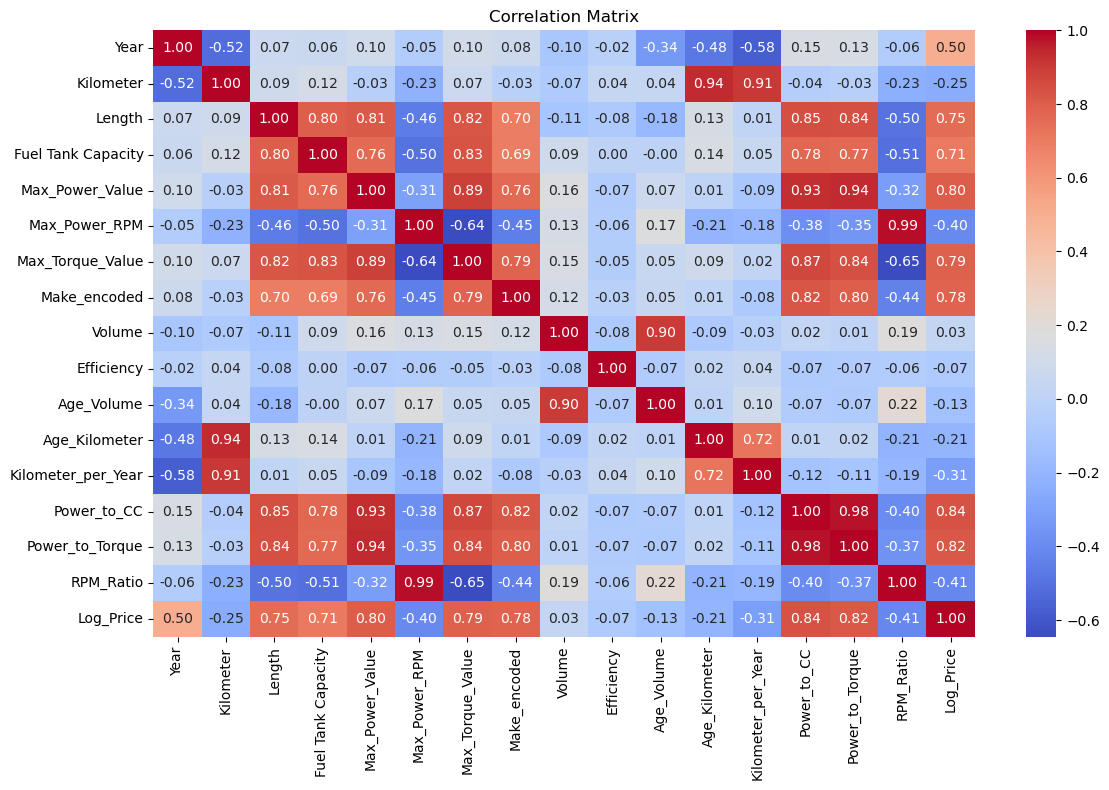

In [10]:
# Kiểm tra mối tương quan giữa các feature với biến mục tiêu
correlation_with_target = df[numerical_features + [target]].corr()[target].sort_values(ascending=False)
print("Tương quan với Log_Price:")
display(correlation_with_target)

# Vẽ biểu đồ tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_features + [target]].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [11]:
# Chuẩn bị dữ liệu cho mô hình
X = df[all_features]
y = df[target]

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước X_test: {X_test.shape}")
print(f"Kích thước y_train: {y_train.shape}")
print(f"Kích thước y_test: {y_test.shape}")

Kích thước X_train: (1317, 30)
Kích thước X_test: (330, 30)
Kích thước y_train: (1317,)
Kích thước y_test: (330,)


In [12]:
# Chuẩn hóa dữ liệu numerical
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Chỉ chuẩn hóa các feature numerical
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# Kiểm tra dữ liệu sau khi chuẩn hóa
print("Dữ liệu sau khi chuẩn hóa:")
display(X_train_scaled.head())

Dữ liệu sau khi chuẩn hóa:


,Year,Kilometer,Length,Fuel Tank Capacity,Max_Power_Value,Max_Power_RPM,Max_Torque_Value,Make_encoded,Volume,Efficiency,...,Owner_First_Owner,Owner_Fourth_Plus_Owner,Owner_New,Owner_Second_Owner,Owner_Third_Owner,Seating_2,Seating_4,Seating_6,Seating_7,Seating_8
966,0.433693,-0.964230,0.272084,0.180945,-0.415251,0.410712,-0.687244,0.190196,-0.841569,-0.228280,...,1,0,0,0,0,0,0,0,0,0
971,0.729179,-0.559608,1.360604,1.844762,1.037417,-1.627577,1.581012,-0.145471,0.321954,-0.092461,...,1,0,0,0,0,0,0,0,1,0
715,0.433693,-0.438009,0.272084,0.180945,-0.415251,0.410712,-0.687244,0.190196,-0.841569,-0.228280,...,1,0,0,0,0,0,0,0,0,0
552,0.433693,-0.377210,-1.450460,-1.349766,-0.212190,-0.515783,-0.350941,-1.007224,0.770681,-0.115067,...,1,0,0,0,0,0,0,0,0,0
1363,1.024664,-1.198005,-1.007325,-0.551134,0.912456,-0.515783,0.221489,0.999363,-0.494689,-0.215188,...,1,0,0,0,0,0,1,0,0,0


In [13]:
# Huấn luyện mô hình hồi quy tuyến tính
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Đánh giá mô hình trên tập train
y_train_pred = model.predict(X_train_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print(f"Kết quả trên tập Train:")
print(f"RMSE: {train_rmse:.4f}")
print(f"R²: {train_r2:.4f}")

# Đánh giá mô hình trên tập test
y_test_pred = model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nKết quả trên tập Test:")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")

Kết quả trên tập Train:
RMSE: 0.2703
R²: 0.9252

Kết quả trên tập Test:
RMSE: 0.2517
R²: 0.9297


Hệ số của các feature trong mô hình:


,Feature,Coefficient,Abs_Coefficient
25,Seating_2,1.021722,1.021722
21,Owner_Fourth_Plus_Owner,-0.706532,0.706532
0,Year,0.396726,0.396726
22,Owner_New,0.331833,0.331833
4,Max_Power_Value,0.315165,0.315165
7,Make_encoded,0.295913,0.295913
18,Fuel_Petrol,-0.212486,0.212486
19,Transmission_is_Automatic,0.210272,0.210272
17,Fuel_Others,0.195050,0.195050
2,Length,0.180629,0.180629


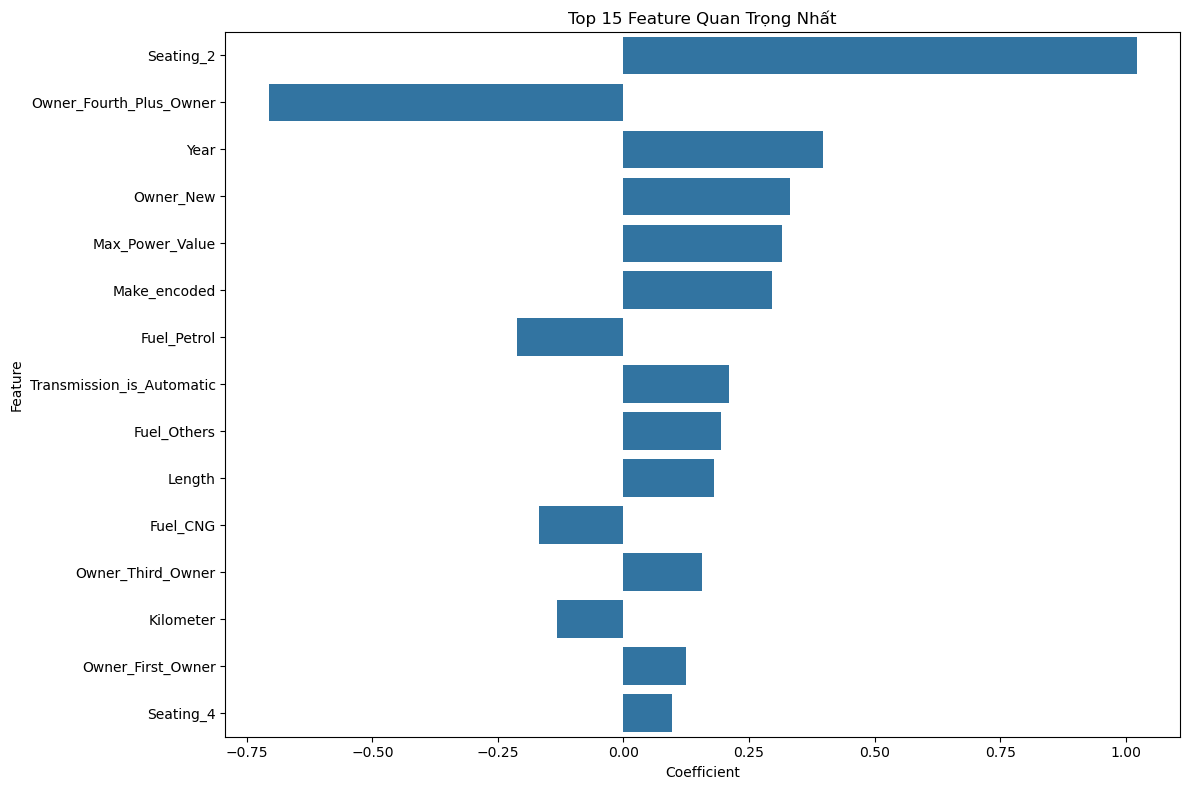

In [14]:
# Phân tích hệ số của mô hình
coefficients = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': model.coef_
})

# Sắp xếp hệ số theo giá trị tuyệt đối giảm dần
coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("Hệ số của các feature trong mô hình:")
display(coefficients)

# Vẽ biểu đồ top 15 feature quan trọng nhất
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.head(15))
plt.title('Top 15 Feature Quan Trọng Nhất')
plt.tight_layout()
plt.show()

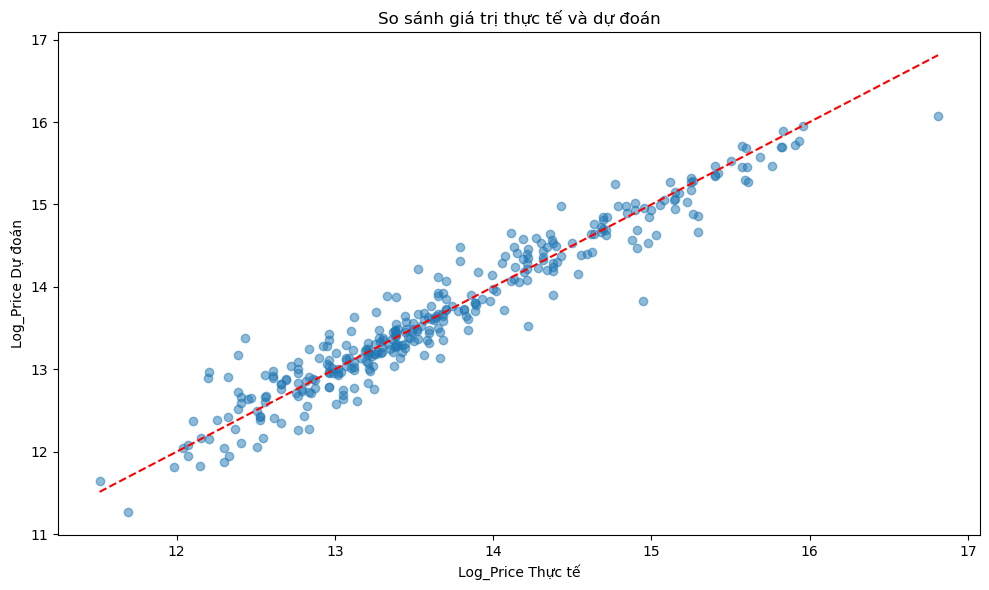

In [15]:
# Kiểm tra dự đoán vs giá trị thực tế trên tập test
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Log_Price Thực tế')
plt.ylabel('Log_Price Dự đoán')
plt.title('So sánh giá trị thực tế và dự đoán')
plt.tight_layout()
plt.show()

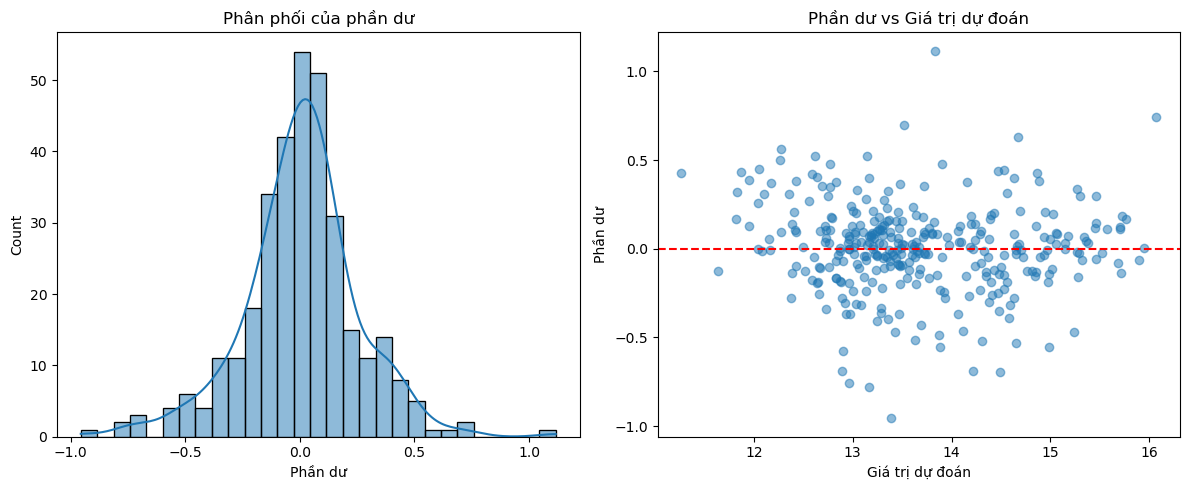

In [16]:
# Kiểm tra phân phối của phần dư
residuals = y_test - y_test_pred

plt.figure(figsize=(12, 5))

# Phân phối phần dư
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Phân phối của phần dư')
plt.xlabel('Phần dư')

# Đồ thị phần dư vs giá trị dự đoán
plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Phần dư vs Giá trị dự đoán')
plt.xlabel('Giá trị dự đoán')
plt.ylabel('Phần dư')

plt.tight_layout()
plt.show()

In [17]:
# Phân loại features thành numerical và categorical
numerical_features = [
    'Year', 'Kilometer', 'Length', 'Width', 'Height', 'Fuel Tank Capacity',
    'Engine_Value', 'Max_Power_Value', 'Max_Power_RPM', 'Max_Torque_Value',
    'Max_Torque_RPM', 'Make_encoded', 'Volume', 'Efficiency', 'Age',
    'Age_Volume', 'Age_Kilometer', 'Kilometer_per_Year', 'Power_to_CC',
    'Power_to_Torque', 'RPM_Ratio'
]

categorical_features = [
    'Fuel_CNG', 'Fuel_Others', 'Fuel_Petrol',
    'Transmission_is_Automatic',
    'Color_Medium', 'Color_Premium', 'Color_Rare', 'Color_Silver', 'Color_Standard',
    'Owner_First_Owner', 'Owner_Fourth_Plus_Owner', 'Owner_New', 'Owner_Second_Owner', 'Owner_Third_Owner',
    'Seller_Commercial Registration', 'Seller_Corporate',
    'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8'
]

# Biến mục tiêu
target = 'Log_Price'

# Kiểm tra và lọc chỉ các cột tồn tại trong DataFrame
numerical_features = [col for col in numerical_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]

print(f"\nSố numerical features: {len(numerical_features)}")
print(f"Số categorical features: {len(categorical_features)}")


Số numerical features: 21
Số categorical features: 21



Tương quan của các feature số với Log_Price:
Log_Price             1.000000
Power_to_CC           0.836604
Power_to_Torque       0.818158
Max_Power_Value       0.804834
Max_Torque_Value      0.793953
Make_encoded          0.784800
Width                 0.766633
Length                0.749502
Fuel Tank Capacity    0.710582
Engine_Value          0.704505
Year                  0.500198
Height                0.175473
Volume                0.032846
Efficiency           -0.067692
Age_Volume           -0.134903
Age_Kilometer        -0.207370
Kilometer            -0.251790
Kilometer_per_Year   -0.312163
Max_Power_RPM        -0.402566
RPM_Ratio            -0.413800
Max_Torque_RPM       -0.486339
Age                  -0.500198
Name: Log_Price, dtype: float64


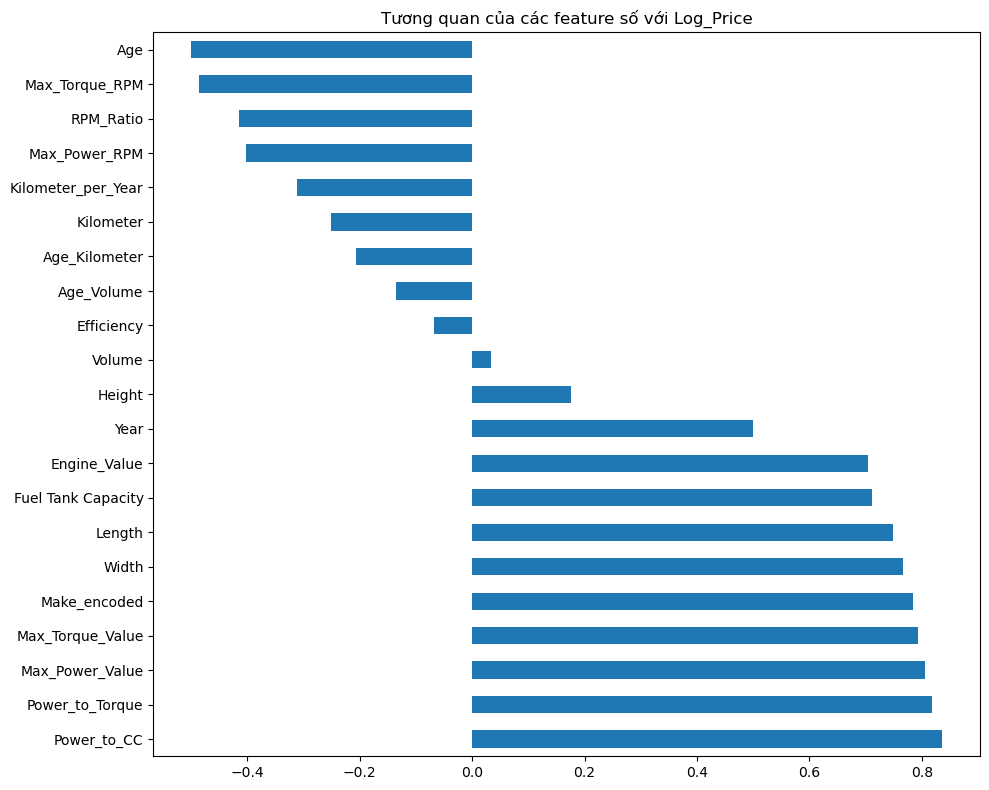


Top 10 feature số có tương quan mạnh nhất với Log_Price:
Power_to_CC: 0.8366
Power_to_Torque: 0.8182
Max_Power_Value: 0.8048
Max_Torque_Value: 0.7940
Make_encoded: 0.7848
Width: 0.7666
Length: 0.7495
Fuel Tank Capacity: 0.7106
Engine_Value: 0.7045
Year: 0.5002


In [18]:
# 1. Phân tích tương quan với biến mục tiêu
# Tính và hiển thị ma trận tương quan cho các feature số
correlation = df[numerical_features + [target]].corr()[target].sort_values(ascending=False)
print("\nTương quan của các feature số với Log_Price:")
print(correlation)

# Vẽ biểu đồ tương quan
plt.figure(figsize=(10, 8))
correlation.drop(target).plot(kind='barh')
plt.title('Tương quan của các feature số với Log_Price')
plt.tight_layout()
plt.show()

# Hiển thị top 10 feature có tương quan mạnh nhất
top_corr_features = correlation.drop(target).abs().sort_values(ascending=False).head(10).index
print("\nTop 10 feature số có tương quan mạnh nhất với Log_Price:")
for feature in top_corr_features:
    print(f"{feature}: {correlation[feature]:.4f}")


Kết quả ANOVA cho các feature categorical:
                                F-statistic        p-value
Transmission_is_Automatic       1253.821193  1.243853e-204
Fuel_Petrol                      186.272821   2.950298e-40
Color_Premium                    135.138718   4.452887e-30
Seating_7                         56.415030   9.574917e-14
Color_Silver                      51.481833   1.088713e-12
Seating_4                         41.169889   1.820119e-10
Fuel_CNG                          34.961151   4.081805e-09
Owner_New                         19.680832   9.758650e-06
Seller_Corporate                  19.226033   1.234778e-05
Seating_2                         16.169917   6.052748e-05
Color_Standard                    15.544184   8.398037e-05
Owner_Fourth_Plus_Owner           15.093075   1.063951e-04
Color_Medium                      12.368398   4.485174e-04
Owner_Third_Owner                  9.713182   1.861148e-03
Seating_6                          6.821025   9.091036e-03
Owner_First_

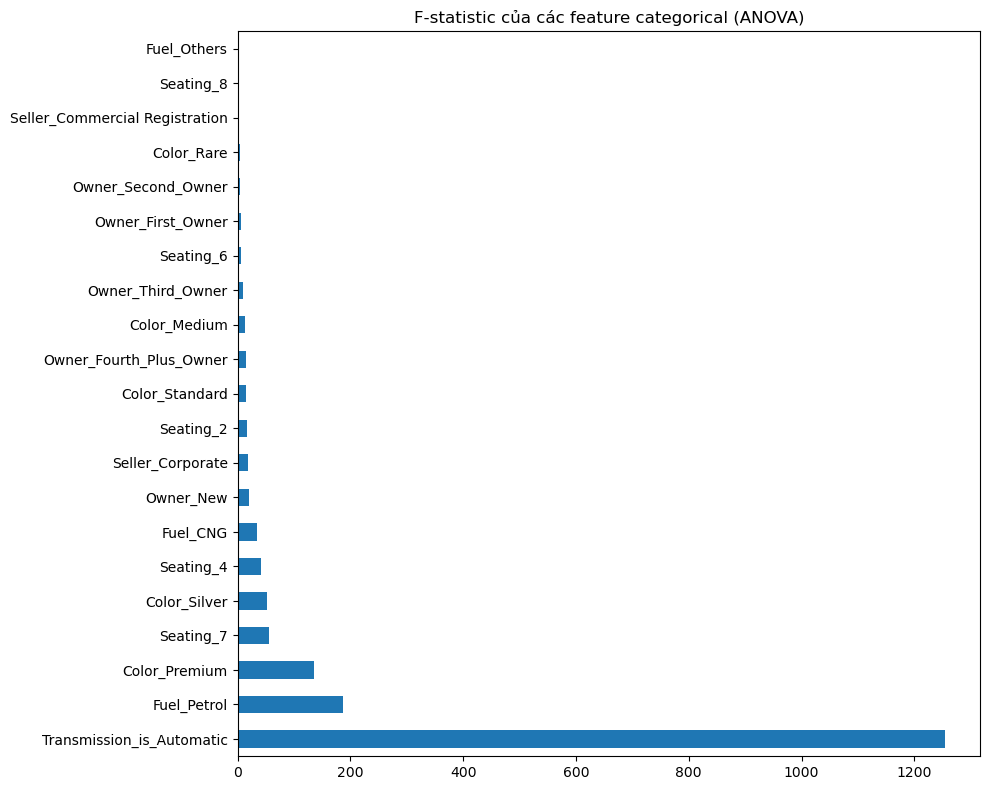


Top 10 feature categorical dựa trên F-statistic:
Transmission_is_Automatic: F=1253.8212, p=0.0000
Fuel_Petrol: F=186.2728, p=0.0000
Color_Premium: F=135.1387, p=0.0000
Seating_7: F=56.4150, p=0.0000
Color_Silver: F=51.4818, p=0.0000
Seating_4: F=41.1699, p=0.0000
Fuel_CNG: F=34.9612, p=0.0000
Owner_New: F=19.6808, p=0.0000
Seller_Corporate: F=19.2260, p=0.0000
Seating_2: F=16.1699, p=0.0001


In [19]:
# 2. Phân tích phương sai cho các feature categorical
from scipy.stats import f_oneway

# Hàm tính ANOVA cho mỗi feature categorical
def calculate_anova(df, categorical_feature, target):
    groups = []
    for value in [0, 1]:  # Giả sử binary features
        group = df[df[categorical_feature] == value][target].values
        if len(group) > 0:
            groups.append(group)

    if len(groups) < 2:
        return 0, 1  # Không đủ nhóm để tính ANOVA

    f_stat, p_value = f_oneway(*groups)
    return f_stat, p_value

# Tính ANOVA cho tất cả categorical features
anova_results = {}
for feature in categorical_features:
    f_stat, p_value = calculate_anova(df, feature, target)
    anova_results[feature] = {'F-statistic': f_stat, 'p-value': p_value}

# Chuyển kết quả thành DataFrame để dễ hiển thị
anova_df = pd.DataFrame.from_dict(anova_results, orient='index')
anova_df = anova_df.sort_values('F-statistic', ascending=False)

print("\nKết quả ANOVA cho các feature categorical:")
print(anova_df)

# Vẽ biểu đồ F-statistic
plt.figure(figsize=(10, 8))
anova_df['F-statistic'].plot(kind='barh')
plt.title('F-statistic của các feature categorical (ANOVA)')
plt.tight_layout()
plt.show()

# Hiển thị top categorical features dựa trên F-statistic
top_categorical_features = anova_df.head(10).index
print("\nTop 10 feature categorical dựa trên F-statistic:")
for feature in top_categorical_features:
    print(f"{feature}: F={anova_df.loc[feature, 'F-statistic']:.4f}, p={anova_df.loc[feature, 'p-value']:.4f}")


Kết quả SelectKBest (f_regression) cho tất cả feature:
                      Feature        Score        P-value
18                Power_to_CC  3836.606752   0.000000e+00
19            Power_to_Torque  3330.548153   0.000000e+00
7             Max_Power_Value  3025.072249   0.000000e+00
9            Max_Torque_Value  2805.293461   0.000000e+00
11               Make_encoded  2637.862344   0.000000e+00
3                       Width  2345.073130  7.919872e-319
2                      Length  2108.588767  5.405856e-297
5          Fuel Tank Capacity  1677.739803  2.030667e-253
6                Engine_Value  1621.008199  2.903284e-247
24  Transmission_is_Automatic  1253.821193  1.243853e-204
14                        Age   548.912720  5.462670e-105
0                        Year   548.912720  5.462670e-105
10             Max_Torque_RPM   509.624666   1.600648e-98
20                  RPM_Ratio   339.870004   3.868672e-69
8               Max_Power_RPM   318.147132   3.391066e-65
23              

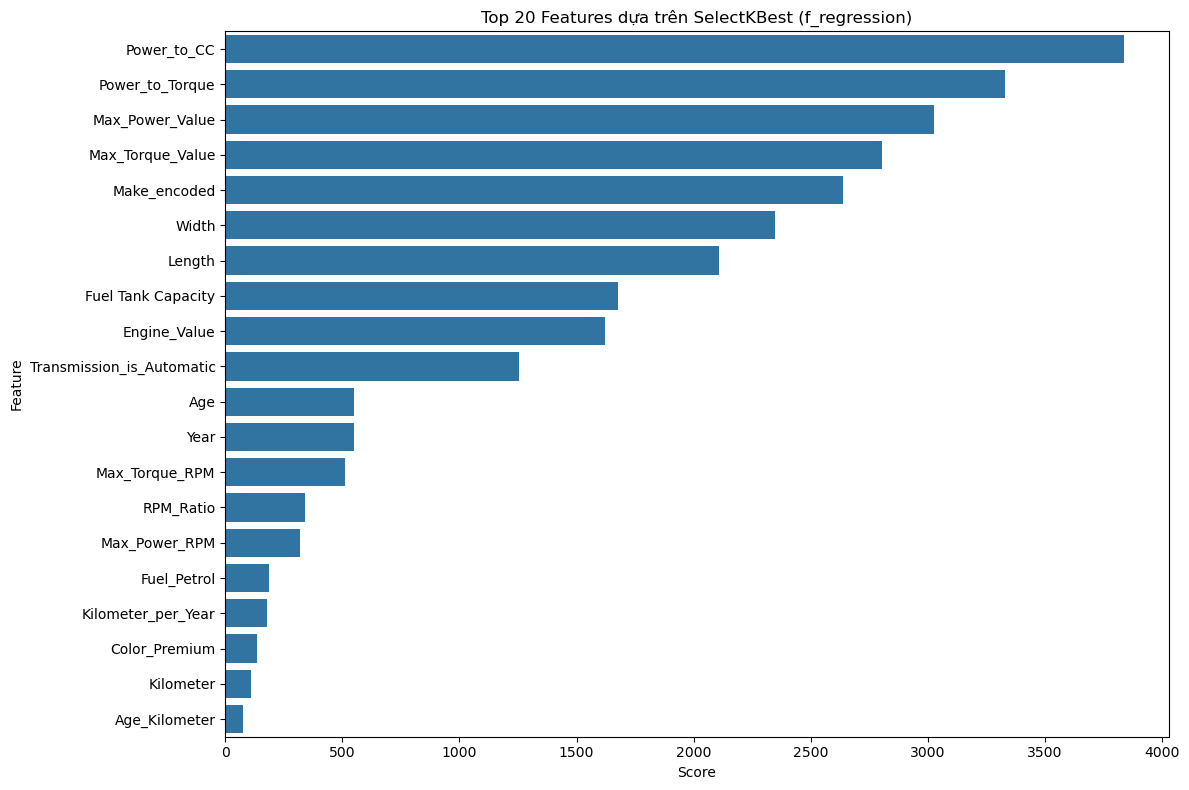


Các feature được chọn bằng SelectKBest:
['Year', 'Kilometer', 'Length', 'Width', 'Fuel Tank Capacity', 'Engine_Value', 'Max_Power_Value', 'Max_Power_RPM', 'Max_Torque_Value', 'Max_Torque_RPM', 'Make_encoded', 'Age', 'Age_Kilometer', 'Kilometer_per_Year', 'Power_to_CC', 'Power_to_Torque', 'RPM_Ratio', 'Fuel_Petrol', 'Transmission_is_Automatic', 'Color_Premium']


In [20]:
# 3. Sử dụng SelectKBest để chọn feature dựa trên F-statistic
from sklearn.feature_selection import SelectKBest, f_regression

# Chuẩn bị dữ liệu
X = df[numerical_features + categorical_features]
y = df[target]

# Chuẩn hóa các feature số
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

# Sử dụng SelectKBest với f_regression
k = min(20, len(X.columns))  # Chọn tối đa 20 feature hoặc ít hơn nếu không đủ
selector = SelectKBest(f_regression, k=k)
selector.fit(X_scaled, y)

# Lấy tên các feature được chọn
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_,
    'P-value': selector.pvalues_
})
feature_scores = feature_scores.sort_values('Score', ascending=False)

print("\nKết quả SelectKBest (f_regression) cho tất cả feature:")
print(feature_scores.head(20))

# Vẽ biểu đồ điểm số của các feature
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(20))
plt.title('Top 20 Features dựa trên SelectKBest (f_regression)')
plt.tight_layout()
plt.show()

# Lấy danh sách các feature được chọn
selected_features_kbest = X.columns[selector.get_support()].tolist()
print("\nCác feature được chọn bằng SelectKBest:")
print(selected_features_kbest)


Kết quả Recursive Feature Elimination:
                           Feature  Rank  Selected
0                             Year     1      True
2                           Length     1      True
7                  Max_Power_Value     1      True
11                    Make_encoded     1      True
14                             Age     1      True
31         Owner_Fourth_Plus_Owner     1      True
23                     Fuel_Petrol     1      True
22                     Fuel_Others     1      True
24       Transmission_is_Automatic     1      True
30               Owner_First_Owner     1      True
33              Owner_Second_Owner     1      True
37                       Seating_2     1      True
35  Seller_Commercial Registration     1      True
34               Owner_Third_Owner     1      True
32                       Owner_New     1      True
5               Fuel Tank Capacity     2     False
8                    Max_Power_RPM     3     False
20                       RPM_Ratio     4  

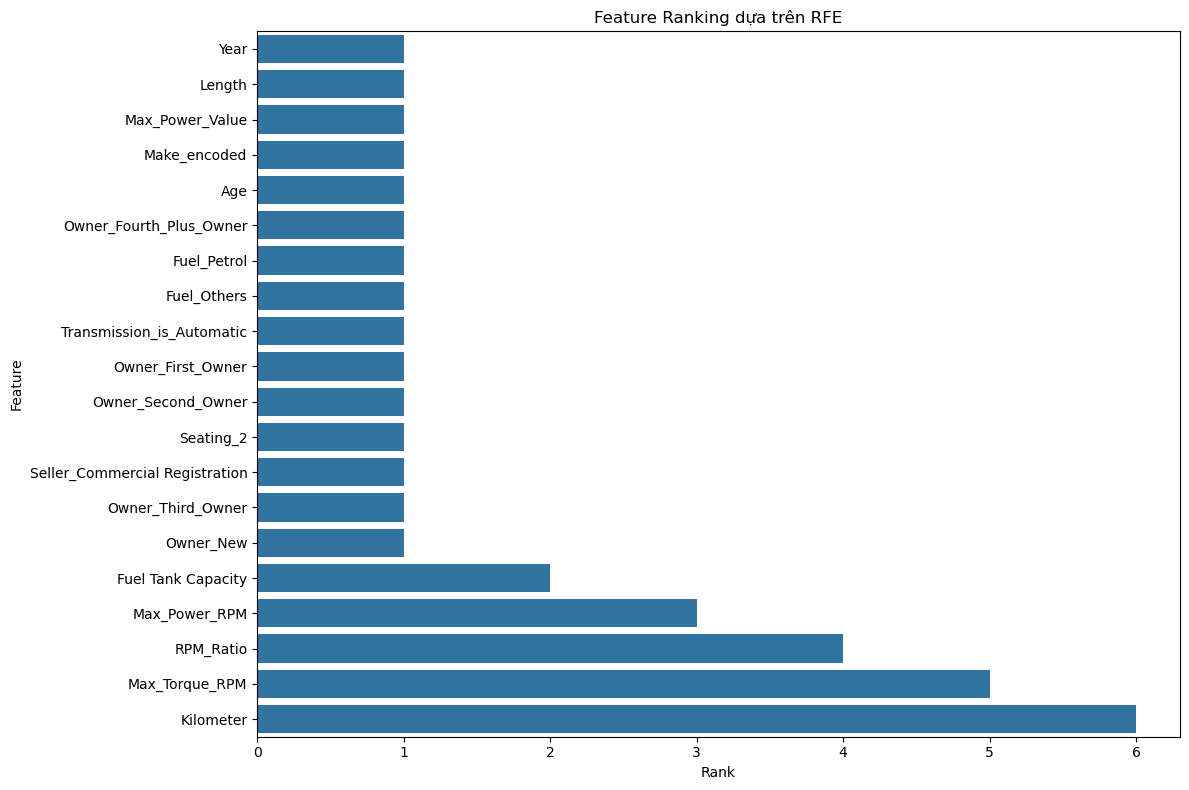


Các feature được chọn bằng RFE:
['Year', 'Length', 'Max_Power_Value', 'Make_encoded', 'Age', 'Owner_Fourth_Plus_Owner', 'Fuel_Petrol', 'Fuel_Others', 'Transmission_is_Automatic', 'Owner_First_Owner', 'Owner_Second_Owner', 'Seating_2', 'Seller_Commercial Registration', 'Owner_Third_Owner', 'Owner_New']


In [21]:
# 4. Sử dụng Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE

# Tạo mô hình cơ sở
base_model = LinearRegression()

# Số lượng feature muốn chọn
n_features_to_select = min(15, len(X.columns))

# Thực hiện RFE
rfe = RFE(estimator=base_model, n_features_to_select=n_features_to_select)
rfe.fit(X_scaled, y)

# Lấy kết quả
rfe_feature_ranks = pd.DataFrame({
    'Feature': X.columns,
    'Rank': rfe.ranking_,
    'Selected': rfe.support_
})
rfe_feature_ranks = rfe_feature_ranks.sort_values('Rank')

print("\nKết quả Recursive Feature Elimination:")
print(rfe_feature_ranks)

# Vẽ biểu đồ ranking
plt.figure(figsize=(12, 8))
sns.barplot(x='Rank', y='Feature', data=rfe_feature_ranks.head(20))
plt.title('Feature Ranking dựa trên RFE')
plt.tight_layout()
plt.show()

# Lấy danh sách các feature được chọn bởi RFE
selected_features_rfe = rfe_feature_ranks[rfe_feature_ranks['Selected'] == True]['Feature'].tolist()
print("\nCác feature được chọn bằng RFE:")
print(selected_features_rfe)


Tầm quan trọng của feature dựa trên Random Forest:
                      Feature  Importance
18                Power_to_CC    0.315544
7             Max_Power_Value    0.189281
19            Power_to_Torque    0.137724
14                        Age    0.065403
0                        Year    0.059367
11               Make_encoded    0.055230
3                       Width    0.052120
15                 Age_Volume    0.044337
9            Max_Torque_Value    0.010207
17         Kilometer_per_Year    0.009707
12                     Volume    0.008557
2                      Length    0.008290
16              Age_Kilometer    0.008114
4                      Height    0.005780
1                   Kilometer    0.004822
5          Fuel Tank Capacity    0.004105
24  Transmission_is_Automatic    0.003766
13                 Efficiency    0.003294
6                Engine_Value    0.002694
10             Max_Torque_RPM    0.002570


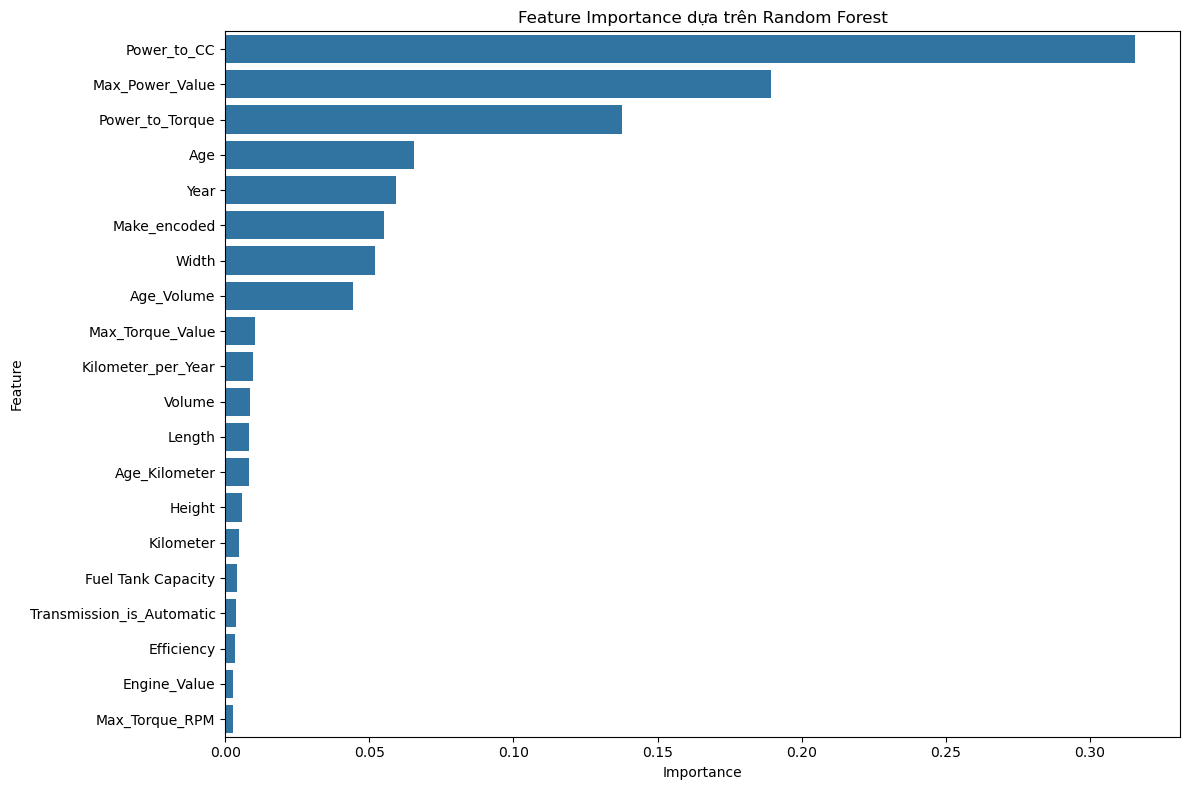


Top 15 feature dựa trên Random Forest:
['Power_to_CC', 'Max_Power_Value', 'Power_to_Torque', 'Age', 'Year', 'Make_encoded', 'Width', 'Age_Volume', 'Max_Torque_Value', 'Kilometer_per_Year', 'Volume', 'Length', 'Age_Kilometer', 'Height', 'Kilometer']


In [22]:
from sklearn.ensemble import RandomForestRegressor

# 5. Sử dụng Random Forest để đánh giá tầm quan trọng của feature
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

# Lấy feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTầm quan trọng của feature dựa trên Random Forest:")
print(feature_importance.head(20))

# Vẽ biểu đồ feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Feature Importance dựa trên Random Forest')
plt.tight_layout()
plt.show()

# Lấy top features dựa trên Random Forest
top_rf_features = feature_importance.head(15)['Feature'].tolist()
print("\nTop 15 feature dựa trên Random Forest:")
print(top_rf_features)


Tổng hợp kết quả lựa chọn feature từ tất cả phương pháp:
                           Feature  Votes
4                           Length      4
15                            Year      4
27                    Make_encoded      4
30                 Max_Power_Value      4
3                  Power_to_Torque      3
28                             Age      3
10                Max_Torque_Value      3
20                     Power_to_CC      3
29                           Width      3
0                      Fuel_Petrol      3
40       Transmission_is_Automatic      3
31              Fuel Tank Capacity      2
32                       Owner_New      2
33                    Engine_Value      2
9                    Age_Kilometer      2
8                        Kilometer      2
1               Kilometer_per_Year      2
11                       Seating_2      2
35                   Color_Premium      2
26                   Max_Power_RPM      1
2                Owner_First_Owner      1
7                 

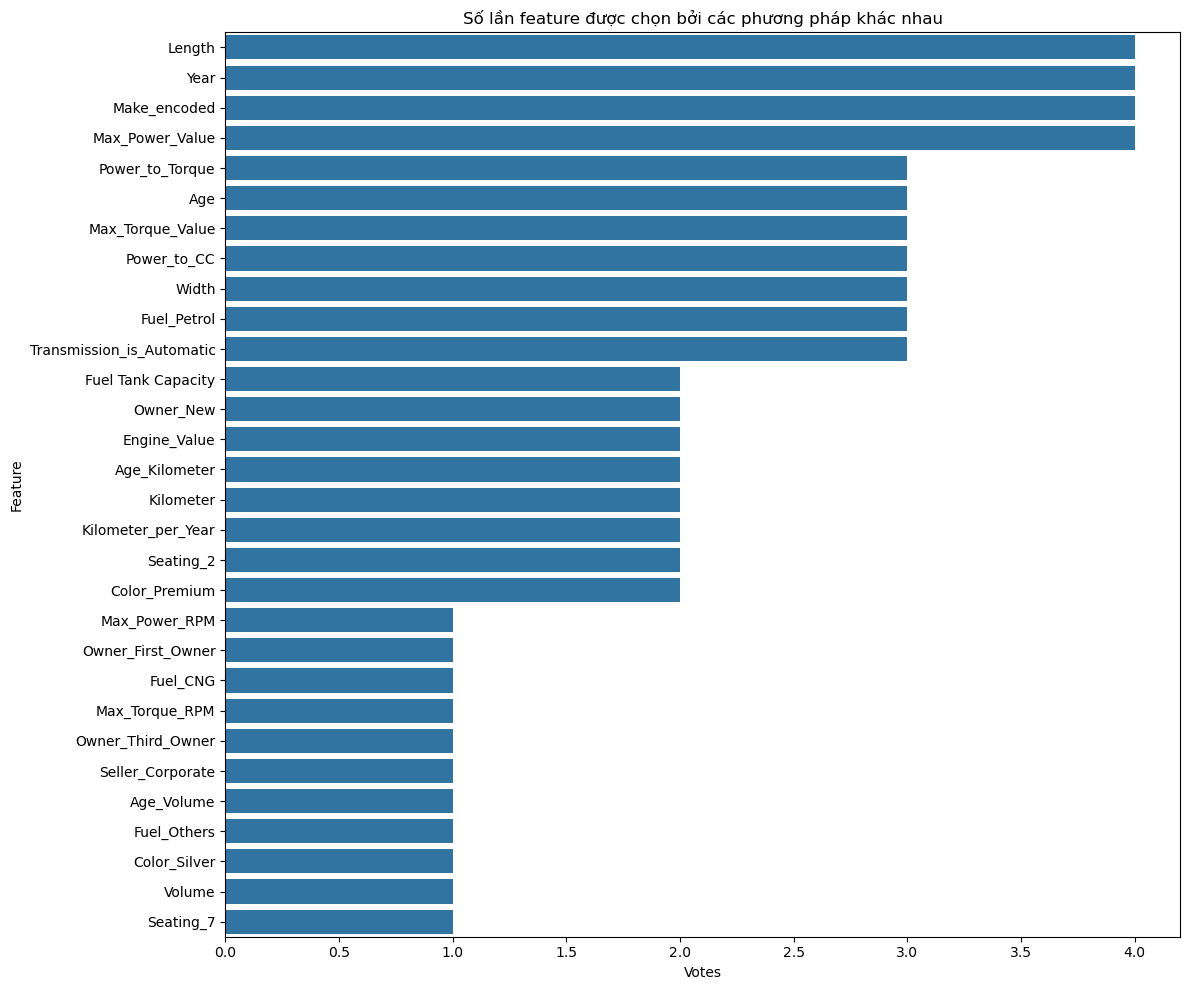

In [23]:
# 6. Tổng hợp kết quả từ các phương pháp
# Đếm số lần mỗi feature được chọn bởi các phương pháp khác nhau
all_features = set(numerical_features + categorical_features)
feature_votes = {feature: 0 for feature in all_features}

# Thêm điểm cho mỗi feature dựa trên các phương pháp khác nhau
# 1. Từ tương quan (top 10)
for feature in top_corr_features:
    feature_votes[feature] += 1

# 2. Từ ANOVA (top 10)
for feature in top_categorical_features:
    feature_votes[feature] += 1

# 3. Từ SelectKBest
for feature in selected_features_kbest:
    feature_votes[feature] += 1

# 4. Từ RFE
for feature in selected_features_rfe:
    feature_votes[feature] += 1

# 5. Từ Random Forest (top 15)
for feature in top_rf_features:
    feature_votes[feature] += 1

# Tạo DataFrame từ kết quả
feature_selection_summary = pd.DataFrame({
    'Feature': list(feature_votes.keys()),
    'Votes': list(feature_votes.values())
})
feature_selection_summary = feature_selection_summary.sort_values('Votes', ascending=False)

print("\nTổng hợp kết quả lựa chọn feature từ tất cả phương pháp:")
print(feature_selection_summary)

# Vẽ biểu đồ tổng hợp
plt.figure(figsize=(12, 10))
sns.barplot(x='Votes', y='Feature', data=feature_selection_summary.head(30))
plt.title('Số lần feature được chọn bởi các phương pháp khác nhau')
plt.tight_layout()
plt.show()

In [24]:
# 7. Đề xuất final features dựa trên các tiêu chí và chú thích của bạn
# Chọn các feature có ít nhất 2 votes và phù hợp với các chú thích
final_features = feature_selection_summary[feature_selection_summary['Votes'] >= 3]['Feature'].tolist()

# Đảm bảo các feature "chọn cứng" luôn được chọn theo yêu cầu
must_have_features = ['Year', 'Kilometer', 'Make_encoded']
for feature in must_have_features:
    if feature not in final_features and feature in df.columns:
        final_features.append(feature)

# Đảm bảo chọn tất cả cùng loại nếu chọn 1 trong số đó
# Nếu có 1 feature Fuel_* thì chọn tất cả
fuel_features = ['Fuel_CNG', 'Fuel_Others', 'Fuel_Petrol']
if any(feature in final_features for feature in fuel_features):
    for feature in fuel_features:
        if feature not in final_features and feature in df.columns:
            final_features.append(feature)

# Nếu có 1 feature Owner_* thì chọn tất cả
owner_features = ['Owner_First_Owner', 'Owner_Fourth_Plus_Owner', 'Owner_New', 'Owner_Second_Owner', 'Owner_Third_Owner']
if any(feature in final_features for feature in owner_features):
    for feature in owner_features:
        if feature not in final_features and feature in df.columns:
            final_features.append(feature)

# Chọn tất cả các feature Seating_* (phải chọn)
seating_features = ['Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8']
for feature in seating_features:
    if feature not in final_features and feature in df.columns:
        final_features.append(feature)

print("\nDanh sách final features được đề xuất:")
print(final_features)
print(f"Tổng số: {len(final_features)} features")

# Phân loại final features thành numerical và categorical
final_numerical_features = [f for f in final_features if f in numerical_features]
final_categorical_features = [f for f in final_features if f in categorical_features]

print("\nFinal numerical features:")
print(final_numerical_features)
print(f"Số lượng: {len(final_numerical_features)}")

print("\nFinal categorical features:")
print(final_categorical_features)
print(f"Số lượng: {len(final_categorical_features)}")


Danh sách final features được đề xuất:
['Length', 'Year', 'Make_encoded', 'Max_Power_Value', 'Power_to_Torque', 'Age', 'Max_Torque_Value', 'Power_to_CC', 'Width', 'Fuel_Petrol', 'Transmission_is_Automatic', 'Kilometer', 'Fuel_CNG', 'Fuel_Others', 'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8']
Tổng số: 19 features

Final numerical features:
['Length', 'Year', 'Make_encoded', 'Max_Power_Value', 'Power_to_Torque', 'Age', 'Max_Torque_Value', 'Power_to_CC', 'Width', 'Kilometer']
Số lượng: 10

Final categorical features:
['Fuel_Petrol', 'Transmission_is_Automatic', 'Fuel_CNG', 'Fuel_Others', 'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8']
Số lượng: 9


In [25]:
# 9. Kiểm tra hiệu suất của mô hình với các feature đã chọn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Chuẩn bị dữ liệu với feature đã chọn
X_selected = df[final_features]
y = df[target]

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Chỉ chuẩn hóa các feature numerical
numerical_in_selected = [f for f in final_numerical_features if f in final_features]
if numerical_in_selected:
    X_train_scaled[numerical_in_selected] = scaler.fit_transform(X_train[numerical_in_selected])
    X_test_scaled[numerical_in_selected] = scaler.transform(X_test[numerical_in_selected])

# Huấn luyện mô hình
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Dự đoán và đánh giá
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print("\nKết quả mô hình với feature đã chọn:")
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")
print(f"Train MSE: {(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"Test MSE: {(mean_squared_error(y_test, y_test_pred)):.4f}")


Kết quả mô hình với feature đã chọn:
Train R²: 0.9217
Test R²: 0.9255
Train MSE: 0.0760
Test MSE: 0.0706


In [26]:
# Tạo 4 bộ features khác nhau
# Mỗi bộ sẽ tập trung vào một khía cạnh khác nhau của dữ liệu

# Bộ 1: Tập trung vào các feature cơ bản và hiệu suất
features_set_1 = [
    # Features cơ bản (chọn cứng)
    'Year', 'Kilometer', 'Make_encoded',

    # Features quan trọng về thông số kỹ thuật
    'Max_Power_Value', 'Engine_Value', 'Fuel Tank Capacity',

    # Features tính toán
    'Efficiency', 'Power_to_CC',

    # Fuel features
    'Fuel_CNG', 'Fuel_Others', 'Fuel_Petrol',

    # Owner features
    'Owner_First_Owner', 'Owner_Fourth_Plus_Owner', 'Owner_New', 'Owner_Second_Owner', 'Owner_Third_Owner',

    # Seating features (bắt buộc)
    'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8',

    # Transmission
    'Transmission_is_Automatic'
]

# Bộ 2: Tập trung vào kích thước và không gian
features_set_2 = [
    # Features cơ bản (chọn cứng)
    'Year', 'Kilometer', 'Make_encoded',

    # Kích thước
    'Length', 'Width', 'Height', 'Volume',

    # Thông số động cơ (bớt đi so với bộ 1)
    'Max_Power_Value',

    # Fuel features
    'Fuel_CNG', 'Fuel_Others', 'Fuel_Petrol',

    # Owner features (bỏ bớt so với bộ 1)
    'Owner_First_Owner', 'Owner_New',

    # Seating features (bắt buộc)
    'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8',

    # Transmission
    'Transmission_is_Automatic',

    # Feature liên quan đến tuổi
    'Age_Volume'
]

# Bộ 3: Tập trung vào động cơ và hiệu suất
features_set_3 = [
    # Features cơ bản (chọn cứng)
    'Year', 'Kilometer', 'Make_encoded',

    # Chi tiết động cơ
    'Max_Power_Value', 'Max_Power_RPM', 'Max_Torque_Value', 'Max_Torque_RPM',

    # Tương quan động cơ
    'Power_to_Torque', 'RPM_Ratio', 'Power_to_CC',

    # Fuel features
    'Fuel_CNG', 'Fuel_Others', 'Fuel_Petrol',

    # Owner feature (chỉ giữ lại cái quan trọng nhất)
    'Owner_First_Owner',

    # Seating features (bắt buộc)
    'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8',

    # Transmission
    'Transmission_is_Automatic'
]

# Bộ 4: Tập trung vào tuổi xe và lịch sử
features_set_4 = [
    # Features cơ bản (chọn cứng)
    'Year', 'Kilometer', 'Make_encoded',

    # Features liên quan tuổi và lịch sử
    'Age_Kilometer', 'Kilometer_per_Year',

    # Thông số cơ bản
    'Max_Power_Value', 'Fuel Tank Capacity',

    # Features tính toán
    'Efficiency',

    # Fuel features
    'Fuel_CNG', 'Fuel_Others', 'Fuel_Petrol',

    # Color features (không có trong các bộ khác)
    'Color_Premium', 'Color_Rare',

    # Owner features
    'Owner_First_Owner', 'Owner_Fourth_Plus_Owner', 'Owner_New', 'Owner_Second_Owner', 'Owner_Third_Owner',

    # Seating features (bắt buộc)
    'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8',

    # Transmission
    'Transmission_is_Automatic',

    # Seller features (chỉ xuất hiện trong bộ này)
    'Seller_Commercial Registration', 'Seller_Corporate'
]

In [27]:
# Hàm kiểm tra sự khác biệt giữa các bộ features
def check_feature_differences(set_a, set_b):
    set_a = set(set_a)
    set_b = set(set_b)

    unique_to_a = set_a - set_b
    unique_to_b = set_b - set_a

    return {
        'unique_to_set_a': list(unique_to_a),
        'unique_to_set_b': list(unique_to_b),
        'total_differences': len(unique_to_a) + len(unique_to_b)
    }

# Kiểm tra sự khác biệt giữa các bộ
comparisons = [
    ('Set 1 vs Set 2', check_feature_differences(features_set_1, features_set_2)),
    ('Set 1 vs Set 3', check_feature_differences(features_set_1, features_set_3)),
    ('Set 1 vs Set 4', check_feature_differences(features_set_1, features_set_4)),
    ('Set 2 vs Set 3', check_feature_differences(features_set_2, features_set_3)),
    ('Set 2 vs Set 4', check_feature_differences(features_set_2, features_set_4)),
    ('Set 3 vs Set 4', check_feature_differences(features_set_3, features_set_4))
]

# In kết quả
for comparison_name, result in comparisons:
    print(f"\n{comparison_name}:")
    print(f"Tổng số khác biệt: {result['total_differences']}")
    if result['total_differences'] < 2:
        print("CẢNH BÁO: Khác biệt ít hơn 2 features!")


Set 1 vs Set 2:
Tổng số khác biệt: 12

Set 1 vs Set 3:
Tổng số khác biệt: 12

Set 1 vs Set 4:
Tổng số khác biệt: 8

Set 2 vs Set 3:
Tổng số khác biệt: 12

Set 2 vs Set 4:
Tổng số khác biệt: 16

Set 3 vs Set 4:
Tổng số khác biệt: 18


In [28]:
# In chi tiết 4 bộ features
def print_feature_set(name, feature_set):
    print(f"\n{name}:")
    print(f"Tổng số features: {len(feature_set)}")

    # Phân loại
    numerical = [f for f in feature_set if f in ['Year', 'Kilometer', 'Length', 'Width', 'Height',
                                                'Fuel Tank Capacity', 'Engine_Value', 'Max_Power_Value',
                                                'Max_Power_RPM', 'Max_Torque_Value', 'Max_Torque_RPM',
                                                'Make_encoded', 'Volume', 'Efficiency', 'Age_Volume',
                                                'Age_Kilometer', 'Kilometer_per_Year', 'Power_to_CC',
                                                'Power_to_Torque', 'RPM_Ratio']]

    categorical = [f for f in feature_set if f not in numerical]

    print(f"Numerical features ({len(numerical)}):")
    for f in numerical:
        print(f"  - {f}")

    print(f"Categorical features ({len(categorical)}):")
    for f in categorical:
        print(f"  - {f}")

print_feature_set("Feature Set 1", features_set_1)
print_feature_set("Feature Set 2", features_set_2)
print_feature_set("Feature Set 3", features_set_3)
print_feature_set("Feature Set 4", features_set_4)


Feature Set 1:
Tổng số features: 22
Numerical features (8):
  - Year
  - Kilometer
  - Make_encoded
  - Max_Power_Value
  - Engine_Value
  - Fuel Tank Capacity
  - Efficiency
  - Power_to_CC
Categorical features (14):
  - Fuel_CNG
  - Fuel_Others
  - Fuel_Petrol
  - Owner_First_Owner
  - Owner_Fourth_Plus_Owner
  - Owner_New
  - Owner_Second_Owner
  - Owner_Third_Owner
  - Seating_2
  - Seating_4
  - Seating_6
  - Seating_7
  - Seating_8
  - Transmission_is_Automatic

Feature Set 2:
Tổng số features: 20
Numerical features (9):
  - Year
  - Kilometer
  - Make_encoded
  - Length
  - Width
  - Height
  - Volume
  - Max_Power_Value
  - Age_Volume
Categorical features (11):
  - Fuel_CNG
  - Fuel_Others
  - Fuel_Petrol
  - Owner_First_Owner
  - Owner_New
  - Seating_2
  - Seating_4
  - Seating_6
  - Seating_7
  - Seating_8
  - Transmission_is_Automatic

Feature Set 3:
Tổng số features: 20
Numerical features (10):
  - Year
  - Kilometer
  - Make_encoded
  - Max_Power_Value
  - Max_Power_RPM


In [29]:
# Tạo code để dễ dàng sử dụng các bộ features
print("\n# Bộ features 1: Cơ bản và hiệu suất")
print("selected_features_1 = [")
for feature in features_set_1:
    print(f"    '{feature}',")
print("]")

print("\n# Bộ features 2: Kích thước và không gian")
print("selected_features_2 = [")
for feature in features_set_2:
    print(f"    '{feature}',")
print("]")

print("\n# Bộ features 3: Động cơ và hiệu suất")
print("selected_features_3 = [")
for feature in features_set_3:
    print(f"    '{feature}',")
print("]")

print("\n# Bộ features 4: Tuổi xe và lịch sử")
print("selected_features_4 = [")
for feature in features_set_4:
    print(f"    '{feature}',")
print("]")


# Bộ features 1: Cơ bản và hiệu suất
selected_features_1 = [
    'Year',
    'Kilometer',
    'Make_encoded',
    'Max_Power_Value',
    'Engine_Value',
    'Fuel Tank Capacity',
    'Efficiency',
    'Power_to_CC',
    'Fuel_CNG',
    'Fuel_Others',
    'Fuel_Petrol',
    'Owner_First_Owner',
    'Owner_Fourth_Plus_Owner',
    'Owner_New',
    'Owner_Second_Owner',
    'Owner_Third_Owner',
    'Seating_2',
    'Seating_4',
    'Seating_6',
    'Seating_7',
    'Seating_8',
    'Transmission_is_Automatic',
]

# Bộ features 2: Kích thước và không gian
selected_features_2 = [
    'Year',
    'Kilometer',
    'Make_encoded',
    'Length',
    'Width',
    'Height',
    'Volume',
    'Max_Power_Value',
    'Fuel_CNG',
    'Fuel_Others',
    'Fuel_Petrol',
    'Owner_First_Owner',
    'Owner_New',
    'Seating_2',
    'Seating_4',
    'Seating_6',
    'Seating_7',
    'Seating_8',
    'Transmission_is_Automatic',
    'Age_Volume',
]

# Bộ features 3: Động cơ và hiệu suất
selected_features_

In [30]:
# Mã để so sánh hiệu suất của 4 bộ features
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Chuẩn bị dữ liệu
feature_sets = {
    "Set 1": features_set_1,
    "Set 2": features_set_2,
    "Set 3": features_set_3,
    "Set 4": features_set_4
}

results = {}

# Đọc lại dữ liệu
df = pd.read_csv('../../Data/Final_train.csv')

# Thêm các feature đã tính toán nếu chưa có
if 'Volume' not in df.columns:
    df['Volume'] = df['Length'] * df['Width'] * df['Height']

if 'Efficiency' not in df.columns:
    df['Efficiency'] = df['Max_Power_Value'] / df['Fuel Tank Capacity'].replace(0, 1)

# Tính tuổi xe (giả sử dữ liệu được thu thập vào năm 2023)
current_year = 2023
if 'Age' not in df.columns:
    df['Age'] = current_year - df['Year']

if 'Age_Volume' not in df.columns:
    df['Age_Volume'] = df['Age'] * df['Volume']

if 'Age_Kilometer' not in df.columns:
    df['Age_Kilometer'] = df['Age'] * df['Kilometer']

if 'Kilometer_per_Year' not in df.columns:
    df['Kilometer_per_Year'] = df['Kilometer'] / df['Age'].replace(0, 1)

if 'Power_to_CC' not in df.columns:
    df['Power_to_CC'] = df['Max_Power_Value'] / df['Engine_Value'].replace(0, 1)

if 'Power_to_Torque' not in df.columns:
    df['Power_to_Torque'] = df['Max_Power_Value'] / df['Max_Torque_Value'].replace(0, 1)

if 'RPM_Ratio' not in df.columns:
    df['RPM_Ratio'] = df['Max_Power_RPM'] / df['Max_Torque_RPM'].replace(0, 1)

# Chọn target
log_target = 'Log_Price'
y_log = df[log_target]

# Tính giá gốc (không log) nếu cần
if 'Price' not in df.columns:
    df['Price'] = np.exp(df['Log_Price'])
y_original = df['Price']

# Đánh giá từng bộ features
for set_name, features in feature_sets.items():
    # Lọc các features có trong DataFrame
    available_features = [f for f in features if f in df.columns]
    if len(available_features) < len(features):
        print(f"Cảnh báo: Bộ {set_name} có {len(features) - len(available_features)} feature không có trong dữ liệu")

    # Chuẩn bị dữ liệu
    X = df[available_features]

    # Chia tập train/test
    X_train, X_test, y_log_train, y_log_test, y_orig_train, y_orig_test = train_test_split(
        X, y_log, y_original, test_size=0.2, random_state=43)

    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Xác định các cột số
    numerical_cols = [col for col in available_features if col in [
        'Year', 'Kilometer', 'Length', 'Width', 'Height',
        'Fuel Tank Capacity', 'Engine_Value', 'Max_Power_Value',
        'Max_Power_RPM', 'Max_Torque_Value', 'Max_Torque_RPM',
        'Make_encoded', 'Volume', 'Efficiency', 'Age_Volume',
        'Age_Kilometer', 'Kilometer_per_Year', 'Power_to_CC',
        'Power_to_Torque', 'RPM_Ratio'
    ]]

    # Chỉ chuẩn hóa các cột số
    if numerical_cols:
        X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
        X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

    # Huấn luyện mô hình
    model = LinearRegression()
    model.fit(X_train_scaled, y_log_train)

    # Đánh giá trên tập test (Log_Price)
    y_log_test_pred = model.predict(X_test_scaled)
    log_rmse = np.sqrt(mean_squared_error(y_log_test, y_log_test_pred))
    log_mae = mean_absolute_error(y_log_test, y_log_test_pred)
    log_mse = mean_squared_error(y_log_test, y_log_test_pred)
    log_r2 = r2_score(y_log_test, y_log_test_pred)

    # Chuyển đổi dự đoán log về giá gốc
    y_orig_test_pred = np.exp(y_log_test_pred)

    # Đánh giá trên giá gốc (không log)
    orig_rmse = np.sqrt(mean_squared_error(y_orig_test, y_orig_test_pred))
    orig_mae = mean_absolute_error(y_orig_test, y_orig_test_pred)
    orig_mse = mean_squared_error(y_orig_test, y_orig_test_pred)
    orig_r2 = r2_score(y_orig_test, y_orig_test_pred)

    # Lưu kết quả
    results[set_name] = {
        'num_features': len(available_features),
        # Metrics trên Log_Price
        'log_rmse': log_rmse,
        'log_mae': log_mae,
        'log_mse': log_mse,
        'log_r2': log_r2,
        # Metrics trên giá gốc
        'price_rmse': orig_rmse,
        'price_mae': orig_mae,
        'price_mse': orig_mse,
        'price_r2': orig_r2
    }

# Tạo DataFrame từ kết quả
results_df = pd.DataFrame.from_dict(results, orient='index')

# In kết quả so sánh
print("\nSo sánh hiệu suất của 4 bộ features:")
print(results_df)

# Format hiển thị số để dễ đọc
pd.set_option('display.float_format', '{:.2f}'.format)
print("\nSo sánh hiệu suất (format):")
print(results_df)

# Xếp hạng các bộ features theo R² trên giá gốc
print("\nXếp hạng các bộ features theo R² trên giá gốc:")
print(results_df.sort_values('price_r2', ascending=False))

# Xếp hạng các bộ features theo RMSE trên giá gốc
print("\nXếp hạng các bộ features theo RMSE trên giá gốc (thấp hơn = tốt hơn):")
print(results_df.sort_values('price_rmse'))

# Tạo bảng so sánh tập trung vào giá gốc
price_metrics = results_df[['num_features', 'price_rmse', 'price_mae', 'price_mse', 'price_r2']]
print("\nMetrics trên giá gốc:")
print(price_metrics)


So sánh hiệu suất của 4 bộ features:
       num_features  log_rmse   log_mae   log_mse    log_r2     price_rmse  \
Set 1            22  0.262760  0.194822  0.069043  0.923454  750076.338703   
Set 2            20  0.258639  0.186707  0.066894  0.925836  755545.114979   
Set 3            20  0.275668  0.209525  0.075993  0.915748  755691.008257   
Set 4            26  0.265222  0.196279  0.070342  0.922013  758286.636573   

           price_mae     price_mse  price_r2  
Set 1  277316.982084  5.626145e+11  0.842319  
Set 2  261168.699811  5.708484e+11  0.840011  
Set 3  311853.987792  5.710689e+11  0.839949  
Set 4  278476.111805  5.749986e+11  0.838848  

So sánh hiệu suất (format):
       num_features  log_rmse  log_mae  log_mse  log_r2  price_rmse  \
Set 1            22      0.26     0.19     0.07    0.92   750076.34   
Set 2            20      0.26     0.19     0.07    0.93   755545.11   
Set 3            20      0.28     0.21     0.08    0.92   755691.01   
Set 4            26    